<a href="https://colab.research.google.com/github/taimursalman/CV_project-fall-22/blob/main/Group_4_v2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup:**

In [1]:
!pip install loguru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 1.9 MB/s 


In [2]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import loguru 
import glob
import shutil
%matplotlib inline

from google.colab import drive
from google.colab import files
import sys

In [3]:
drive.mount('/content/drive')

!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/test_set.zip
!unzip test_set.zip

sys.path.append('/content/drive/My Drive/lanenet-lane-detection')


Streaming output truncated to the last 5000 lines.
   creating: clips/0530/1492626847734235723_0/
  inflating: clips/0530/1492626847734235723_0/20.jpg  
  inflating: clips/0530/1492626847734235723_0/19.jpg  
  inflating: clips/0530/1492626847734235723_0/18.jpg  
  inflating: clips/0530/1492626847734235723_0/17.jpg  
  inflating: clips/0530/1492626847734235723_0/16.jpg  
  inflating: clips/0530/1492626847734235723_0/15.jpg  
  inflating: clips/0530/1492626847734235723_0/14.jpg  
  inflating: clips/0530/1492626847734235723_0/13.jpg  
  inflating: clips/0530/1492626847734235723_0/12.jpg  
  inflating: clips/0530/1492626847734235723_0/11.jpg  
  inflating: clips/0530/1492626847734235723_0/10.jpg  
  inflating: clips/0530/1492626847734235723_0/9.jpg  
  inflating: clips/0530/1492626847734235723_0/8.jpg  
  inflating: clips/0530/1492626847734235723_0/7.jpg  
  inflating: clips/0530/1492626847734235723_0/6.jpg  
  inflating: clips/0530/1492626847734235723_0/5.jpg  
  inflating: clips/0530/149

In [4]:
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt

Cloning into 'yolov7'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1094 (delta 0), reused 1 (delta 0), pack-reused 1091
Receiving objects: 100% (1094/1094), 69.85 MiB | 30.09 MiB/s, done.
Resolving deltas: 100% (522/522), done.
/content/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.9 MB/s 


**Extracting labels from json files:**

In [5]:
json_pred = [json.loads(line) for line in open('/content/drive/MyDrive/CV_Project/test_set.zip (Unzipped Files)/test_tasks_0627.json').readlines()]
json_gt = [json.loads(line) for line in open('/content/drive/MyDrive/CV_Project/test_label.json').readlines()]

test_size = len(json_gt)

**Extracting all required information:**

In [6]:
pred_lanes = []
run_time = []
gt_lanes = []
y_samples = []
raw_imgs = []
for i in range(test_size):
    pred = json_pred[i]
    gt = json_gt[i]

    run_time.append(pred['run_time'])
    gt_lanes.append(gt['lanes'])
    y_samples.append(gt['h_samples'])
    raw_imgs.append('/content/' + gt['raw_file'])

print(run_time[0])
print(gt_lanes[0])
print(y_samples[0])
print(raw_imgs[0])

1000
[[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 648, 636, 626, 615, 605, 595, 585, 575, 565, 554, 545, 536, 526, 517, 508, 498, 489, 480, 470, 461, 452, 442, 433, 424, 414, 405, 396, 386, 377, 368, 359, 349, 340, 331, 321, 312, 303, 293, 284, 275, 265, 256, 247, 237, 228, 219], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 681, 692, 704, 716, 728, 741, 754, 768, 781, 794, 807, 820, 834, 847, 860, 873, 886, 900, 913, 926, 939, 952, 966, 979, 992, 1005, 1018, 1032, 1045, 1058, 1071, 1084, 1098, 1111, 1124, 1137, 1150, 1164, 1177, 1190, 1203, 1216, 1230, 1243, 1256, 1269], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 713, 746, 778, 811, 845, 880, 916, 951, 986, 1022, 1057, 1092, 1128, 1163, 1198, 1234, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 754, 806, 858, 909, 961, 1013, 1064, 1114, 1164, 1213, 1263, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2

##### **Adding ground truth labels:**

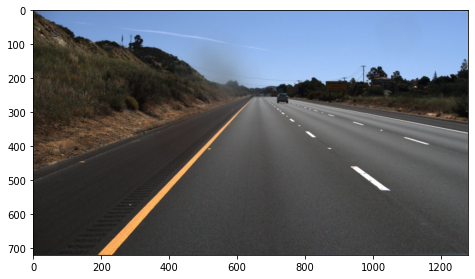

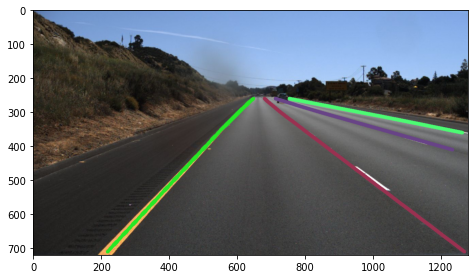

In [7]:
labeled_imgs = []


for i in range(test_size):
    img = plt.imread(raw_imgs[i])
    l_img = img.copy()

    #Label coordinates as a list of tuples
    gt_labels = [[(x, y) for (x, y) in zip(lane, y_samples[i]) if x >= 0] for lane in gt_lanes[i]]

    for lane in gt_labels:
        cv2.polylines(l_img, np.int32([lane]), isClosed=False, color=(np.random.randint(30, 255),np.random.randint(30, 255),np.random.randint(30, 255)), thickness=10)
    
    labeled_imgs.append(l_img)
#Printing sample imgs.
img = plt.imread(raw_imgs[0])
l_img = labeled_imgs[0]

fig1 = plt.figure()
fig1.set_figwidth(8)
fig1.set_figheight(4.5)
plt.imshow(img)
plt.show()


fig2 = plt.figure()
fig2.set_figwidth(8)
fig2.set_figheight(4.5)
plt.imshow(l_img)
plt.show()

**Creating a smaller dataset of 15 clips:**

In [8]:
!mkdir '/content/test'
!mkdir '/content/test/clips'

mode = 0o666

#Each folder
for folder in glob.glob('/content/clips/*'):
    folder_name = folder.split('/')[-1]
    parent_dir = '/content/test/clips'
    folder_path = os.path.join(parent_dir, folder_name)

    if not os.path.exists(folder_path):
        os.mkdir(folder_path, mode)

    #Each video
    for video in glob.glob('/content/clips/' + folder_name + '/*')[0:5]:
        video_name = video.split('/')[-1]
        parent_dir = folder_path
        video_path = os.path.join(parent_dir, video_name)
        if not os.path.exists(video_path):
            os.mkdir(video_path, mode)

        #Each frame
        for frame in glob.glob('/content/clips/' + folder_name + '/' + video_name + '/*'):
            frame_name = frame.split('/')[-1]
            
            #Copying files
            src = '/content/clips/' + folder_name + '/' + video_name + '/' + frame_name
            dst = '/content/test/clips/' + folder_name + '/' + video_name + '/' + frame_name
            shutil.copyfile(src,dst)


## **Lane detection:**

In [9]:
!python '/content/drive/MyDrive/CV_Project/lanenet-lane-detection/evaluate_lanenet_on_tusimple.py' --image_dir '/content/test/clips' --weights_path '/content/drive/MyDrive/CV_Project/BiseNetV2_LaneNet_Tusimple_Model_Weights/tusimple_lanenet.ckpt' --save_dir '/content/output'

/content/drive/.shortcut-targets-by-id/1ZT0P9fwu1NSb9LkMULlFzFcaVjMmeBqY/CV_Project/lanenet-lane-detection/semantic_segmentation_zoo/cnn_basenet.py:352: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  return tf.compat.v1.layers.batch_normalization(inputs=inputdata, training=is_training, name=name, scale=scale)
2022-12-11 18:27:44.978401: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
  0% 0/300 [00:00<?, ?it/s]2022-12-11 18:27:49.039148: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 67108864 exceeds 10% of free system memory.
2022-12-11 18:27:49.130465: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6

#### **Extracting lane data from json files:**

In [10]:
lane_data = {}

for folder in glob.glob('/content/output/*'):
    folder_name = folder.split('/')[-1]
    lane_data[folder_name] = {}
    for video in glob.glob(folder + '/*'):
        video_name = video.split('/')[-1]
        lane_data[folder_name][video_name] = {}
        for json_file in glob.glob(video + '/*.json'):
            json_file_name = json_file.split('/')[-1].split('.')[0]
            with open(json_file, 'r') as read_from:
                lane_dict = json.load(read_from)
            lane_data[folder_name][video_name][json_file_name] = lane_dict['src_lane_pts']

#print(lane_data['0530'])

##### **Vanishing point estimation given lane data:**

All lanes in an image are assumed to be parallel.

The first and the last sample is extracted.

The intersection point is computed for each corresponding pair of lines for adjacent lanes.

The vanashing point is the average of all such intersection points.

In [11]:
#Returns 5 equations given the lane points.
def computeLaneLines(src_lane_pts, img_path):
    line_eqs = []
    
    old_img = plt.imread(img_path).copy()
    new_img = np.zeros(np.shape(old_img), dtype='uint8')
    for i in range(len(src_lane_pts)):
        p1 = np.array([src_lane_pts[i][0][0], src_lane_pts[i][0][1], 1.0])
        p2 = np.array([src_lane_pts[i][50][0], src_lane_pts[i][50][1], 1.0])
      
        
        color = (np.random.randint(30, 255),np.random.randint(30, 255),np.random.randint(30, 255))
        a = cv2.polylines(new_img, np.int32([src_lane_pts[i]]), isClosed=False, color=color, thickness=5)
        
        #Computing the cross product.
        line_eqs.append(np.cross(p1, p2))
    
    return line_eqs, new_img

#Compute the average vanishing point.
def computeAveragePoint(line_eqs):
    # print(line_eqs)
    vanishing_points = []
    for i in range(len(line_eqs)-1):
        vanishing_points.append(np.cross(line_eqs[i],line_eqs[i+1]))

    for i in range(len(vanishing_points)):
        vanishing_points[i][0] /= vanishing_points[i][2]
        vanishing_points[i][1] /= vanishing_points[i][2]
        vanishing_points[i][2] /= vanishing_points[i][2]


    return np.mean(np.array(vanishing_points), axis=0)

def plotAll(img, vanishing_point):    
    fig2 = plt.figure()
    fig2.set_figwidth(8)
    fig2.set_figheight(4.5)
    # print(np.shape(vanishing_point))
    a, b, _ = vanishing_point
    print(vanishing_point)
    # a = 20
    # b = 20
    plt.plot(a, b, marker="v", color="white")
    plt.imshow(img)
    plt.show()  


f = False
#Vanishing point estimation
vanishing_points = {}
for folder in lane_data:
    vanishing_points[folder] = {}
    for video in lane_data[folder]:
        vanishing_points[folder][video] = {}
        for frame in lane_data[folder][video]:
            img_path = "/content/output/" + folder + "/" + video + "/" + frame + ".jpg"
            if f == False:
                a = folder 
                b = video 
                c = frame
                f = True
            line_eqs, new_img = computeLaneLines(lane_data[folder][video][frame], img_path)
            vanishing_points[folder][video][frame] = computeAveragePoint(line_eqs)
            
            # plotAll(new_img, vanishing_points[folder][video][frame])
print(a, b, c)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0531 1492628938835510564 17


## **Dynamic Homography Estimation:**


### **Blue and Red Point Estimation:**

In [12]:
#helper function. to be ignored
def f(w):
  for i in range(len(w) - 1):
    if w[i][1] > w[i + 1][1]:
      return False
  return True

#### **V1:**

In [13]:
#Function to get the blue and red points for a particular lane
def computeBlueAndRedPoints(l_data):
  np.set_printoptions(suppress = True)
  np. set_printoptions(precision=2)
  my_lanes = l_data
  my_lanes_len = len(my_lanes)
  min = 100000.0
  minI = 0
  max = -1.0
  maxI = 0



  for i in range(my_lanes_len):

    if(my_lanes[i][0][0]) < min:
      minI = i
      min = my_lanes[i][0][0]
    if(my_lanes[i][0][0]) > max:
      maxI = i
      max = my_lanes[i][0][0]
    
  
  #Firstly, we choose 4 blue points. Top 2 will be at the ~80%th lane height and bottom 2 will be at the ~95%th height because of the distribution of points on the line in the image
  #We take blue points from the first and the last lane respectively
  first_lane_length = len(my_lanes[minI])
  first_lane_top_index = int(first_lane_length * 0.8)
  first_lane_bottom_index = int(first_lane_length * 0.95)

  print("Min index is ", minI)
  print("First lane top index =", first_lane_top_index)
  print("First_lane_bottom_index =", first_lane_bottom_index)

  blue_point_top_left = np.array([my_lanes[minI][first_lane_top_index][0], my_lanes[minI][first_lane_top_index][1]], dtype='int32')
  blue_point_bottom_left = np.array([my_lanes[minI][first_lane_bottom_index][0], my_lanes[minI][first_lane_bottom_index][1]], dtype='int32')

  # Since the adjacent blue points have to be at the same height, we forcefully keep the y-value of the ones on the right the same as the ones on the left
  last_lane_length = len(my_lanes[maxI])
  last_lane_top_index = int(last_lane_length * 0.8)
  last_lane_bottom_index = int(last_lane_length * 0.95)

  print("max index is", maxI)
  print("last_lane_top_index is", last_lane_top_index)
  print("last_lane_bottom_index is", last_lane_bottom_index)

  blue_point_top_right = np.array([my_lanes[maxI][last_lane_top_index][0], blue_point_top_left[1]], dtype='int32')
  blue_point_bottom_right = np.array([my_lanes[maxI][last_lane_bottom_index][0], blue_point_bottom_left[1]], dtype='int32')

  #Now, we arbitrarily pick some red points. The red points have to form a rectangle as well. We will pick the red points at positions 0.2 and 0.8 along the line that connects the blue points on the same line horizontally
  red_point_top_left = blue_point_top_left + ((blue_point_top_right - blue_point_top_left) * 0.2)
  red_point_top_right = blue_point_top_left + ((blue_point_top_right - blue_point_top_left) * 0.8)

  red_point_bottom_left = np.array([red_point_top_left[0], blue_point_bottom_left[1]])
  red_point_bottom_right = np.array([red_point_top_right[0], red_point_bottom_left[1]])

  
  return [[blue_point_top_left ,blue_point_top_right, blue_point_bottom_left, blue_point_bottom_right], [red_point_top_left, red_point_top_right, red_point_bottom_left, red_point_bottom_right]]


#### **V2:**

In [14]:
#note: incomplete. this isthe one with the interpolation
def computeBlueAndRedPoints_version_two(l_data):
  np.set_printoptions(suppress = True)
  np. set_printoptions(precision=2)


  #Here, 
  my_lanes = l_data
  my_lanes_len = len(my_lanes)
  min = 100000.0
  minI = 0
  max = -1.0
  maxI = 0 # maxI is the index of the rightmost 

  for i in range(my_lanes_len):
    
    if(my_lanes[i][0][0]) < min:
      minI = i
      min = my_lanes[i][0][0]
    if(my_lanes[i][0][0]) > max:
      maxI = i
      max = my_lanes[i][0][0]

  #Now, we compute the blue points on the right side first
  bp_tr_x = int(my_lanes[maxI, 0.80, 0])
  bp_tr_y = int(my_lanes[maxI, 0.80, 1])
  blue_point_top_right = np.array([bp_tr_x, bp_tr_y], dtype='int32')

  bp_br_x = int(my_lanes[maxI, 0.95, 0])
  bp_br_y = int(my_lanes[maxI, 0.95, 1])
  blue_point_bottom_right = np.array([bp_br_x, bp_br_y], dtype='int32')


  # To compute the points on the left, we will use the interpolation thing
  
  # Firstly, the top left point
  inter_min = 1000000
  inter_bool = False
  bp_tl_x = -1
  bp_tl_y = bp_tr_y

  for i in range(len(my_lanes[minI])):
    if inter_bool == False:
      inter_min = i  
      inter_bool = True
    else:
      if int(my_lanes[minI][i][1]) < bp_tr_y:
        inter_min = i
      elif int(my_lanes[minI][i][1]) == bp_tr_y:
        bp_tl_x = int(my_lanes[minI][i][0])
      else:
        # we went past the y value, meaning that it is time to stop the loop now
        break

  if bp_tl_x == -1:
    #This is the (not so) fun part
    prev_point = my_lanes[minI][inter_min - 1]
    next_point = my_lanes[minI][inter_min]

    #To get a point with the same y-coordinate as the one in the top right point, we use the equation of a line in non-homoenous coordinates
    gradient = (prev_point[1] - next_point[1]) / (prev_point[0] - next_point[0])
    c = prev_point[1] - (gradient * prev_point[0])

    #Now..
    bp_tl_x = (bp_tr_y - c) / gradient

  #Now, the whoole thing for the bottom left point
  inter_min = 1000000
  inter_bool = False
  bp_bl_x = -1
  bp_bl_y = bp_br_y

  for i in range(len(my_lanes[minI])):
    if inter_bool == False:
      inter_min = i  
      inter_bool = True
    else:
      if int(my_lanes[minI][i][1]) < bp_br_y:
        inter_min = i
      elif int(my_lanes[minI][i][1]) == bp_br_y:
        bp_bl_x = int(my_lanes[minI][i][0])
      else:
        # we went past the y value, meaning that it is time to stop the loop now
        break

  if bp_bl_x == -1:
    #This is the (not so) fun part
    prev_point = my_lanes[minI][inter_min - 1]
    next_point = my_lanes[minI][inter_min]

    #To get a point with the same y-coordinate as the one in the top right point, we use the equation of a line in non-homoenous coordinates
    gradient = (prev_point[1] - next_point[1]) / (prev_point[0] - next_point[0])
    c = prev_point[1] - (gradient * prev_point[0])

    #Now..
    bp_bl_x = (bp_br_y - c) / gradient


  blue_point_top_left = np.array([bp_tl_x, bp_tl_y])
  blue_point_top_right = np.array([bp_tr_x, bp_tr_y])
  blue_point_bottom_left = np.array([bp_bl_x, bp_bl_y])
  blue_point_bottom_right = np.array([bp_br_x, bp_br_y])

  # return [[blue_point_top_left ,blue_point_top_right, blue_point_bottom_left, blue_point_bottom_right], [red_point_top_left, red_point_top_right, red_point_bottom_left, red_point_bottom_right]]


#### **V3:**

In [15]:
#Function to get the blue and red points for a particular lane. This approach uses y-lines
def computeBlueAndRedPoints_v3(l_data, img_shape):
  np.set_printoptions(suppress = True)
  np.set_printoptions(precision=2)

  my_lanes = l_data
  my_lanes_len = len(my_lanes)


  #picking the lanes here
  min = 100000.0
  minI = 0
  max = -1.0
  maxI = 0
  for i in range(my_lanes_len):
    if(my_lanes[i][0][0]) < min:
      minI = i
      min = my_lanes[i][0][0]
    if(my_lanes[i][0][0]) > max:
      maxI = i
      max = my_lanes[i][0][0]
    
  #Y-lines here
  top_y_line = int(0.45 * img_shape[0])
  bottom_y_line = int(0.65 * img_shape[0])

  bp_tl_index = -1
  bp_bl_index = -1
  min_t = img_shape[0]
  min_b = img_shape[0]

  for i in range(len(my_lanes[minI])):
    if abs(my_lanes[minI][i][1] - top_y_line) < min_t:
      min_t = abs(my_lanes[minI][i][1] - top_y_line)
      bp_tl_index = i
    
    if abs(my_lanes[minI][i][1] - bottom_y_line) < min_b:
      min_b = abs(my_lanes[minI][i][1] - bottom_y_line)
      bp_bl_index = i

  blue_point_top_left = np.array([my_lanes[minI][bp_tl_index][0], my_lanes[minI][bp_tl_index][1]], dtype='int32')
  blue_point_bottom_left = np.array([my_lanes[minI][bp_bl_index][0], my_lanes[minI][bp_bl_index][1]], dtype='int32')

  bp_tr_index = -1
  bp_br_index = -1
  min_t = img_shape[0]
  min_b = img_shape[0]

  for i in range(len(my_lanes[maxI])):
    if abs(my_lanes[maxI][i][1] - top_y_line) < min_t:
      min_t = abs(my_lanes[maxI][i][1] - top_y_line)
      bp_tr_index = i
    
    if abs(my_lanes[maxI][i][1] - bottom_y_line) < min_b:
      min_b = abs(my_lanes[maxI][i][1] - bottom_y_line)
      bp_br_index = i

  blue_point_top_right = np.array([my_lanes[maxI][bp_tr_index][0], my_lanes[maxI][bp_tr_index][1]], dtype='int32')
  blue_point_bottom_right = np.array([my_lanes[maxI][bp_br_index][0], my_lanes[maxI][bp_br_index][1]], dtype='int32')

  #Now, we pick some red points. The red points have to form a rectangle as well. We will pick the red points at positions 0.2 and 0.8 along the line that connects the blue points on the same line horizontally
  red_point_top_left = blue_point_top_left + ((blue_point_top_right - blue_point_top_left) * 0.2)
  red_point_top_right = blue_point_top_left + ((blue_point_top_right - blue_point_top_left) * 0.8)

  red_point_bottom_left = np.array([red_point_top_left[0], blue_point_bottom_left[1]])
  red_point_bottom_right = np.array([red_point_top_right[0], red_point_bottom_left[1]])

  
  return [[blue_point_top_left ,blue_point_top_right, blue_point_bottom_left, blue_point_bottom_right], [red_point_top_left, red_point_top_right, red_point_bottom_left, red_point_bottom_right]]


##### **Homography matrix parameters computation:**

In [16]:
def computeHomographyParams(blue_points, red_points):

  return cv2.getPerspectiveTransform(blue_points, red_points)

  # #The blue points transform into the red points
  # point_count = len(blue_points)

  # the_matrix = np.zeros((2 * point_count, 9))


  # for i in range(len(blue_points)):
  #   x = blue_points[i][0]
  #   y = blue_points[i][1]

  #   xp = red_points[i][0]
  #   yp = red_points[i][0]

  #   row_x = np.array([-x, -y, -1, 0, 0, 0, xp * x, xp * y, xp])
  #   row_y = np.array([0, 0, 0, -x, -y, -1, yp * x, yp * y, yp])

  #   the_matrix[i * 2] = row_x.reshape((1, 9))
  #   the_matrix[i * 2 + 1] = row_y.reshape((1, 9))

  # # print(the_matrix)
  # # return the_matrix
  # # print(the_matrix.shape)

  # #Where the magic happens
  # u, s, v = np.linalg.svd(the_matrix)
  # np.set_printoptions(suppress = True)
  # np. set_printoptions(precision=2)
  # S = np.zeros((u.shape[1], v.shape[0]))
  # for i in range(len(s)):
  #   S[i, i] = s[i]
  # #The solution will then be the last row of V
  # solution = v[v.shape[0] - 1]
  
  # return solution



  # # print("U is")
  # # print(u.shape, S.shape, v.shape)
  # # print(S)
  # # print(the_matrix)
  # # print("\n\n\n")
  # # t = np.matmul(u, S)
  # # x = np.matmul(t, v)
  # # print(x)
  # # print(u)
  # # print("\n\n")
  # # print("S is")
  # # print(S)
  # # print("\n\n")
  # # print("V is")
  # # print(v)

##### **Generating masks for image:**

In [17]:
def boundingBox(lanes):
    pts = []
    for lane in lanes:
        pts = pts + lane

    pts = np.array(pts)

    min = np.amin(pts,axis=0)
    max = np.amax(pts,axis=0)
    return min, max

def maskFrame(folder, video, frame, l_data):
    image_path = '/content' + '/clips/' + folder + '/' + video + '/' + frame + '.jpg'
    lanes = l_data[folder][video][frame]

    image = plt.imread(image_path)

    shape = image.shape
    mask = np.zeros(shape, dtype=np.uint8)

    min, max = boundingBox(lanes)
    min = np.int32(min)
    max = np.int32(max)
    pts = np.array([[min[0], min[1]],  [max[0], min[1]],[max[0], max[1]], [min[0], max[1]]])

    cv2.bitwise_and(mask, image, mask=None)
    mask = cv2.fillPoly(mask, [pts], (255,255,255))
    return cv2.bitwise_and(mask, image, mask=None)


# masked_image = maskFrame('0530', '1492626047222176976_0', '4', lane_data)

##### **Getting cropping parameters for image:**

In [18]:
def zero_one(points, img_size):
  tl_index = -1
  tl = img_size[0]

  br_index = -1
  br = -1 

  for i in range(len(points)):
    if points[i][0] < tl:
      tl_index = i
      tl = points[i][0]
    if points[i][1] > br:
      br_index = i
      br = points[i][1]
  
  top_left_point = points[tl_index].astype('int32')
  bottom_right_point = points[br_index].astype('int32')
  # print("top_left_point:", top_left_point)
  # print("bottom_right_point:", bottom_right_point)

  top_left_point = top_left_point - np.array([img_size[1] * 0.15, img_size[0] * 0.15], dtype='int32')
  for i in range(len(top_left_point)):
    if top_left_point[i] < 0:
      top_left_point[i] = 0
  
  bottom_right_point = bottom_right_point + np.array([img_size[1] * 0.1, img_size[0] * 0.1], dtype='int32')
  for i in range(len(top_left_point)):
    if top_left_point[i] >= img_size[1-i]:
      top_left_point[i] = img_size[1-i] - 1

  # return (int(top_left_point[1]), int(bottom_right_point[1], int(top_left_point[0]), int(bottom_right_point[1]))
  return (top_left_point[0], top_left_point[1], bottom_right_point[0], bottom_right_point[1])


##### **Image Warping:**

In [19]:
def warper(folder_f, video_v, frame_f, l_data):


  img_path = "/content/output/" + folder_f + "/" + video_v + "/" + frame_f
  previous_image = plt.imread(img_path)
  frame_no = frame_f.split('.')[0]
  toSend = l_data[folder_f][video_v][frame_no]
  image_shape = previous_image.shape
  
  x = computeBlueAndRedPoints_v3(toSend, image_shape)
  y = np.array(x[0], dtype='float32') # blue points
  z = np.array(x[1], dtype='float32') # red points
 

  homography_matrix = computeHomographyParams(y, z)
  
  #If we are going to crop:
  a_1, b_1, c_1, d_1 = zero_one(z, image_shape)
  
#   masked_image = maskFrame(folder_f, video_v, frame_no, l_data)
  new_image = cv2.warpPerspective(previous_image, homography_matrix, dsize=(int(previous_image.shape[1]), int(previous_image.shape[0])), flags=cv2.INTER_LINEAR)

  
  # If we are going to crop
  cropped_new_image = new_image[b_1: d_1, a_1: c_1]
  # for i in toSend:
  #   for j in i:
  #     plt.plot(j[0], j[1], marker="v",color="white")
  # for i in y:
  #   plt.plot(i[0], i[1], marker="o", color="blue")

  # for i in z:
  #   plt.plot(i[0], i[1], marker="o", color="red")
  

  return cropped_new_image




## **Creating top view videos:**

In [20]:
!mkdir '/content/videos'
mode = 0o666


#Each folder
for folder in glob.glob('/content/test/clips/*'):
    folder_name = folder.split('/')[-1]
    parent_dir = '/content/videos'
    folder_path = os.path.join(parent_dir, folder_name)

    if not os.path.exists(folder_path):
        os.mkdir(folder_path, mode)

    #Each video
    for video in glob.glob('/content/test/clips/' + folder_name + '/*'):
        video_name = video.split('/')[-1]

        parent_dir = folder_path
        video_path = os.path.join(parent_dir, video_name)
        if not os.path.exists(video_path):
            os.mkdir(video_path, mode)
        
        frame_list = []
        #Each frame
        for frame in sorted(glob.glob('/content/test/clips/' + folder_name + '/' + video_name + '/*')):
            frame_name = frame.split('/')[-1]
            frame_no = frame_name.split('.')[0]
            frame_list.append(warper(folder_name, video_name, frame_name, lane_data))

        output = cv2.VideoWriter(video_path + '/' + video_name + '.mp4', cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 20, (frame_list[0].shape[1], frame_list[0].shape[0]))
        
        for i in range(0,len(frame_list)):
            output.write(frame_list[i])

        output.release()
    

!zip -r '/content/videos.zip' '/content/videos'

  adding: content/videos/ (stored 0%)
  adding: content/videos/0531/ (stored 0%)
  adding: content/videos/0531/1492628938835510564/ (stored 0%)
  adding: content/videos/0531/1492628938835510564/1492628938835510564.mp4 (deflated 2%)
  adding: content/videos/0531/1492627868152045480/ (stored 0%)
  adding: content/videos/0531/1492627868152045480/1492627868152045480.mp4 (deflated 3%)
  adding: content/videos/0531/1492627985180730080/ (stored 0%)
  adding: content/videos/0531/1492627985180730080/1492627985180730080.mp4 (deflated 4%)
  adding: content/videos/0531/1492636578474936420/ (stored 0%)
  adding: content/videos/0531/1492636578474936420/1492636578474936420.mp4 (deflated 6%)
  adding: content/videos/0531/1492635576477496714/ (stored 0%)
  adding: content/videos/0531/1492635576477496714/1492635576477496714.mp4 (deflated 4%)
  adding: content/videos/0601/ (stored 0%)
  adding: content/videos/0601/1495485259531947927/ (stored 0%)
  adding: content/videos/0601/1495485259531947927/14954852

In [26]:
!python detect.py --weights yolov7.pt   --source /content/clips/0530/1492626911695395235_0/1.jpg --project content/yolo_outputs

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='content/yolo_outputs', save_conf=False, save_txt=False, source='/content/clips/0530/1492626911695395235_0/1.jpg', update=False, view_img=False, weights=['yolov7.pt'])
YOLOR 🚀 v0.1-116-g8c0bf3f torch 1.13.0+cu116 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model Summary: 306 layers, 36905341 parameters, 6652669 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
1 car, Done. (1456.9ms) Inference, (2.2ms

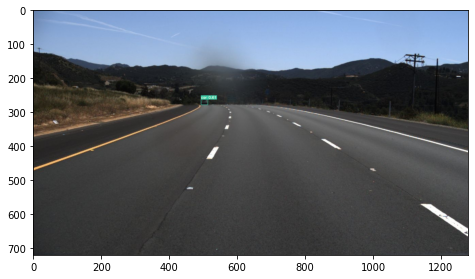

In [29]:
img = plt.imread('content/yolo_outputs/exp3/1.jpg')

fig1 = plt.figure()
fig1.set_figwidth(8)
fig1.set_figheight(4.5)
plt.imshow(img)
plt.show()